In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from LSsurf.unique_by_rows import unique_by_rows
import pointCollection as pc
import glob
import re
import h5py
import pandas as pd

In [2]:
def read_xovers(xover_dir, verbose=False, wildcard='*', r_limits=[0, 1.e7], delta_t_limit=2592000):
    tiles=glob.glob(xover_dir+'/*.h5')
    with h5py.File(tiles[0],'r') as h5f:
        fields=[key for key in h5f['data_0'].keys()]
    
    D=[]
    meta=[]
    #X=[]
    tile_re=re.compile('E(.*)_N(.*).h5')
    count=0
    tiles=glob.glob(xover_dir+'/'+wildcard+'.h5')
    for tile in tiles:
        m=tile_re.search(tile)
        if m is not None:
            r2=np.float(m.group(1))**2+np.float(m.group(2))**2
            if (r2 < r_limits[0]**2) or (r2 > r_limits[1]**2):
                continue
        try:
            this_D=[pc.data().from_h5(tile, field_dict={gr : fields}) for gr in ['data_0','data_1']]
            this_meta=pc.data().from_h5(tile, field_dict={None:['slope_x', 'slope_y','grounded']})
            if delta_t_limit is not None:
                good=np.abs(this_D[1].delta_time[:,0]-this_D[0].delta_time[:,0]) < delta_t_limit
                for Di in this_D:
                    Di.index(good)
                this_meta.index(good)
            count += 1
        except KeyError:
            if verbose:
                print("failed to read " + tile)
            continue

        D.append(this_D)
        meta.append(this_meta)
        if np.mod(count, 100)==0:
            print(f'{count} out of {len(tiles)}')

    meta=pc.data().from_list(meta)
    v={}
    for field in fields:
        vi=[]
        for Di in D:
            vi.append(np.r_[[np.sum(getattr(Di[ii], field)*Di[ii].W, axis=1) for ii in [0, 1]]])
        v[field]=np.concatenate(vi, axis=1).T
    delta={field:np.diff(v[field], axis=1) for field in fields}
    bar={field:np.mean(v[field], axis=1) for field in fields}
    return v,  delta,  bar, {key:getattr(meta, key) for key in meta.fields}

In [3]:
def spread_vs_slope(delta0, rounded_slope_0, ind=None):
    if ind is not None:
        delta=delta0.copy_subset(ind)
        rounded_slope=rounded_slope_0[ind]
    else:
        delta=delta0
        rounded_slope=rounded_slope_0
    _, slope_bins = unique_by_rows(rounded_slope, return_dict=True)
    slope_vals=np.zeros(len(slope_bins.keys()))+np.NaN
    spread=np.zeros_like(slope_vals)+np.NaN
    N=np.zeros_like(slope_vals)+np.NaN
    for ii, key in enumerate(slope_bins.keys()):
        slope_vals[ii]=np.nanmedian(rounded_slope[slope_bins[key]])
        dsub=delta.h_li[slope_bins[key]]
        ind=np.ones_like(dsub, dtype=bool)
        for k in np.arange(6):
            sigma=np.sqrt(np.nanmean(dsub[ind]**2))
            ind = np.abs(dsub) < 3*sigma
        spread[ii]=sigma #ss.scoreatpercentile(np.abs(dsub), 0.68)
        N[ii]=np.sum(ind)
    return slope_vals, spread, N           

def slope_regression(slope, spread, max_slope):
    these= (slope < max_slope)
    G=np.ones((np.sum(these), 2))
    G[:,1]=slope[these]**2
    m=np.linalg.solve(G.T.dot(G), G.T.dot(spread[these]**2))
    V_model=G.dot(m)
    V_model[V_model<0]=np.NaN
    return [np.sqrt(m[0]), np.sqrt(m[1])], np.sqrt(V_model)



In [6]:
xover_dir='/Volumes/ice2/ben/scf/AA_06/004/xovers/cycle_09/'
ATL06_fields=['BP','LR','W','cycle_number','rgt','h_li','h_li_sigma','x','y','spot']

v0,  delta0,  bar0, meta0 = read_xovers(xover_dir)
meta0['slope_mag']=np.abs(meta0['slope_x']+1j*meta0['slope_y'])


100 out of 1557
200 out of 1557
300 out of 1557
400 out of 1557
500 out of 1557
600 out of 1557
700 out of 1557
800 out of 1557
900 out of 1557
1000 out of 1557
1100 out of 1557
1200 out of 1557
1300 out of 1557
1400 out of 1557
1500 out of 1557


In [7]:
v=pc.data().from_dict(v0)
delta=pc.data().from_dict(delta0)
bar=pc.data().from_dict(bar0)
meta=pc.data().from_dict(meta0)

good=(meta.grounded==1) 
print(np.mean(good))
v.index(good)
delta.index(good)
bar.index(good)
meta.index(good)
meta.assign({'slope':np.abs(meta.slope_x+1j*meta.slope_y)})


0.9838332346122823


<class 'pointCollection.data.data'> with shape (6492712,),
with fields:
['grounded', 'slope_x', 'slope_y', 'slope_mag', 'slope']

Text(0.5, 1.0, 'all spots, cycle 09')

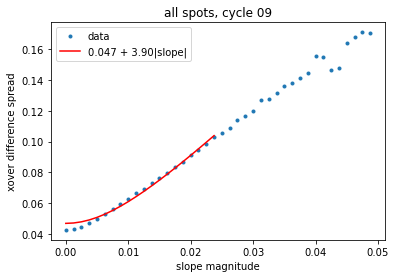

In [8]:
max_slope=0.025
slope_bin_width=0.00125
slope_bin=np.round(meta.slope/slope_bin_width)*slope_bin_width

slope_vals, spread, N=spread_vs_slope(delta, slope_bin)
slope_fit=slope_regression(slope_vals[N>500], spread[N>500], max_slope)
to_plot = (N>500) & (slope_vals <0.05)
plt.figure(); plt.plot(slope_vals[to_plot], spread[to_plot],'.', label='data')
plt.plot(slope_vals[slope_vals < max_slope], slope_fit[1],'r', label='%3.3f + %3.2f|slope|' % tuple(slope_fit[0]))
plt.xlabel('slope magnitude')
plt.ylabel('xover difference spread')
plt.legend()
plt.title('all spots, cycle 09')


In [9]:
slope_fit[0]
'%3.3f + %3.2f|slope|' % tuple(slope_fit[0])

'0.047 + 3.90|slope|'

In [10]:
fits={}

for spot0 in range(1,7):
    for spot1 in range(1, spot0+1):
        #print((spot0, spot1))
        these = ((v.spot[:,0]==spot0) & (v.spot[:,1]==spot1)) | ((v.spot[:,0]==spot1) & (v.spot[:,1]==spot0))
        slope_vals, spread, N=spread_vs_slope(delta[these], slope_bin[these])
        fits[(spot0, spot1)]=slope_regression(slope_vals[N>100], spread[N>100], max_slope)[0]


In [11]:
spots=np.c_[list(fits.keys())]
sigma_0=np.c_[[fits[tuple(spots[row,:])][0] for row in range(spots.shape[0])]]
sigma_x=np.c_[[fits[tuple(spots[row,:])][1] for row in range(spots.shape[0])]]

Text(0.5, 0, 'spot')

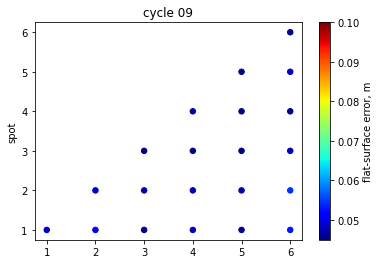

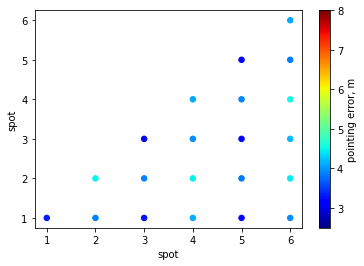

In [12]:
plt.figure(); plt.scatter(spots[:,0], spots[:,1], 30, c=sigma_0, cmap='jet', vmin=0.045, vmax=0.1); 
plt.colorbar(label='flat-surface error, m')
plt.title('cycle 09')
plt.ylabel('spot')
plt.figure(); plt.scatter(spots[:,0], spots[:,1], 30, c=sigma_x, cmap='jet', vmin=2.5, vmax=8); 
plt.colorbar(label='pointing error, m')
plt.ylabel('spot')
plt.xlabel('spot')


# code to find per-rgt errors

In [13]:
# error analysis to pick out the worst RGTs:
DD={}
sign=[1, -1]
dh_dict={}
y_atc_dict={}
spot_dict={}
dt_dict={}
for col in [0, 1]:
    # loop over combinations of cycles and tracks in each column
    u_ct, D_ct = unique_by_rows(np.c_[np.round(v.rgt[:, col]).astype(int), np.round(v.cycle_number[:,col]).astype(int)], return_dict=True)
    for ct in u_ct:
        key=tuple(ct)
        if key not in dh_dict:
            dh_dict[key]=[]
            y_atc_dict[key]=[]
            spot_dict[key]=[]
            dt_dict[key]=[]
        these=D_ct[key]
        good=(bar.atl06_quality_summary[these]<0.01) & (meta.slope_mag[these]<0.02)
        if np.any(good):
            dh_dict[key].append(delta.h_li[these[good]]*sign[col])
            y_atc_dict[key].append(v.y_atc[these,col][good])
            spot_dict[key].append(v.spot[these,col][good])
            dt_dict[key].append(v.delta_time[these,col][good])

In [14]:
# make a dict holding per-rgt ct_stats_d

ct_stats_d={}
for key in dh_dict:
    if len(dh_dict[key]) ==0:
        continue
    dh=np.concatenate([item.ravel() for item in dh_dict[key]])
    spot=np.concatenate([item.ravel() for item in spot_dict[key]])
    y=np.concatenate([item.ravel() for item in y_atc_dict[key]])
    tt=np.concatenate([item.ravel() for item in dt_dict[key]])
    ct_stats_d[key]={
        'med':np.nanmedian(dh),
        'count':dh.size,
        'mad':np.nanmedian(np.abs(dh-np.nanmedian(dh))),
       'good_count':np.nansum(np.abs(dh)<1).astype(np.float),
        'y_atc':np.nanmean(y[np.abs(spot-3.5)<0.6]),
        't0':np.nanmin(tt),
        't1':np.nanmax(tt)}

In [15]:
#flatten the ct_stats_dictionary

keys=list(ct_stats_d.keys())
ct_stats={
    'med':np.array([ct_stats_d[key]['med'] for key in keys]),
    'mad':np.array([ct_stats_d[key]['mad'] for key in keys]),
    'count':np.array([ct_stats_d[key]['count'] for key in keys]),
    'good_count':np.array([ct_stats_d[key]['good_count'] for key in keys]),
    'rgt':np.array([key[0] for key in keys]),
    'cycle':np.array([key[1] for key in keys]),
    'y':np.array([ct_stats_d[key]['y_atc'] for key in keys]),
    't0':np.array([ct_stats_d[key]['t0'] for key in keys]),
    't1':np.array([ct_stats_d[key]['t1'] for key in keys])
}

for field in ['med', 'mad', 'good_count']:
    ct_stats[field][ct_stats['count']<100]=np.NaN


found rgts with medians greater than 8 cm:
[498 499 618]


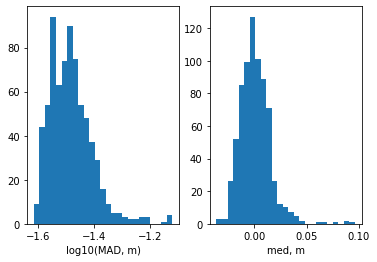

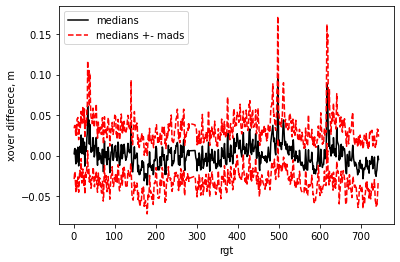

In [16]:
           
fig=plt.figure();
ax=fig.add_subplot(121)
ax.hist(np.log10(ct_stats['mad']), 25)
ax.set_xlabel('log10(MAD, m)')
ax=fig.add_subplot(122)
ax.hist(ct_stats['med'], 25)
ax.set_xlabel('med, m')

fig=plt.figure();
ax=fig.add_subplot(111)
ax.plot(ct_stats['rgt'], ct_stats['med'], 'k', label='medians')
ax.plot(ct_stats['rgt'], ct_stats['med']-ct_stats['mad'], 'r--', label='medians +- mads')
ax.plot(ct_stats['rgt'], ct_stats['med']+ct_stats['mad'] , 'r--')
ax.legend()
ax.set_xlabel('rgt')
ax.set_ylabel('xover differece, m')

print('found rgts with medians greater than 8 cm:')
print(ct_stats['rgt'][np.abs(ct_stats['med'])>0.08])

plt.show()
